<a href="https://colab.research.google.com/github/wtyjoycee/TaobaoProductAnalysis/blob/main/TaobaoLDA_BerTopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Package Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import matplotlib.pyplot as plt
import matplotlib
import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import seaborn as sns
import warnings
import spacy

nlp = spacy.load("en_core_web_sm")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

import requests
from collections import Counter
from PIL import Image
from io import BytesIO
from transformers import BertModel, BertTokenizer

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.preprocessing import StandardScaler

from keras.applications.vgg16 import VGG16

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



## 2. Data Import

In [17]:
# product categories
df_cate = pd.read_excel("drive/MyDrive/category_dict.xlsx")
df_dict = df_cate.iloc[:, 0:2].set_index('categories').to_dict()
cate_dict = df_dict['sub_categories']

# product information
df = pd.read_excel("drive/MyDrive/taobao_data.xlsx")
df.head(3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0.1         20000 non-null  int64  
 1   Unnamed: 0           20000 non-null  int64  
 2   category             5831 non-null   object 
 3   id                   20000 non-null  int64  
 4   product_name         19992 non-null  object 
 5   price                20000 non-null  float64
 6   shipping_location    19999 non-null  object 
 7   product_description  20000 non-null  object 
 8   store_name           20000 non-null  object 
 9   store_link           20000 non-null  object 
 10  product_link         20000 non-null  object 
 11  product_image        20000 non-null  object 
 12  sub_category         20000 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 2.0+ MB


## Data Clean

In [ ]:
# columns clean
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')

# punctuation and lemma
def remove_punctuation(text):
  res = re.sub(r'[^\w\s]', '', text)

  doc = nlp(res)
  res = ""
  for token in doc:
    res = res + token.lemma_ + " "
  return res

df.product_name = df.apply(lambda x: remove_punctuation(x.product_name), axis=1)

# clean the categories
df['sub_category'] = df.category
df['category'] = df.sub_category.map(lambda x: cate_dict[x])

In [ ]:
df.to_csv('drive/MyDrive/clean_taobao_data.xlsx')

# LDA data pre-processing

In [ ]:
df.product_name[2:5]

2    361 yoga mat floor mat home yoga fitness mat f...
3    La Chapelle girl nightwear autumn and winter 2...
4    lead socket lamp head with switch two or three...
Name: product_name, dtype: object

In [ ]:
df_sample = df.sample(20000)
product_names = df_sample.product_name

In [ ]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and w.isalpha()]
    return tokens

# Apply preprocessing to each product name
processed_names = [preprocess(name) for name in product_names]
dictionary = Dictionary(processed_names)
dictionary.filter_extremes(no_below=50, no_above=0.5) #filter words more than 50 docs, less than 50%
corpus = [dictionary.doc2bow(doc) for doc in processed_names] #counts

# num_topics = 5  # Change as needed
# passes = 10  # Number of passes through the corpus during training
# Apply LDA
#lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)

# LDA model fitting

In [1]:
# calcluate perplextiy
def perplexity(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=15))
    print(ldamodel.log_perplexity(corpus))
    return ldamodel.log_perplexity(corpus)

# calcluate coherence
def coherence(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30)
    ldacm = CoherenceModel(model=ldamodel, texts=processed_names, dictionary=dictionary, coherence='c_v')
    print(num_topics, ', ', ldacm.get_coherence())
    return ldacm.get_coherence()

In [2]:
x = range(1,30)
# z = [perplexity(i) for i in x]  # if perplxity
y = [coherence(i) for i in x]
plt.plot(x, y)
plt.xlabel('numbers of topcis')
plt.ylabel('coherence value')
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('#Topcis-Coherence')
plt.show()

NameError: ignored

In [ ]:
# best model
topics = 16  # Change as needed
passes = 30  # Number of passes through the corpus during training
lda_model = LdaModel(corpus, num_topics = topics, id2word=dictionary, passes=passes)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
topics_dict = {
    0: "bowl",
    1: "desk",
    2: "cabinet",
    3: "mat",
    4: "curtain",
    5: "light",
    6: "pillow",
    7: "box",
    8: "bed",
    9: "decoration",
    10: "cushion",
    11: "car",
    12: "table",
    13: "equipment",
    14: "cup",
    15: "clock"
}

In [ ]:
product_topic = []
for product_name in processed_names:
  bow = dictionary.doc2bow(product_name)  # Convert document into the bag-of-words (BoW) format
  topics = lda_model.get_document_topics(bow)  #
  most_relevant_topic = max(topics, key=lambda x: x[1])
  product_topic.append(most_relevant_topic)
product_topic = [list(x) for x in product_topic]

In [ ]:
df_temp = pd.DataFrame(product_topic)
df_temp.columns = ['topics_num', 'prob']
df_temp['topic'] = df_temp.topics_num.map(lambda x: topics_dict[x])
df_sample = df_sample.reset_index()
df_sample['topic'] = df_temp.topic
df_sample['topic_prob'] = df_temp.prob

df_sample.sample(3)

In [ ]:
topics

In [ ]:
df_temp = df_sample.groupby(['category', 'topic'])[['product_name']].count().unstack()
columns = [x[1] for x in df_temp.columns]
df_temp.columns = columns
df_temp = df_temp.fillna(0)

sns.set_context({"figure.figsize":(8,8)})
sns.heatmap(data=df_temp,square=True)

# Bert topics

In [ ]:
df = pd.read_csv('drive/MyDrive/data_sample.xlsx')

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance

In [ ]:
df_sample = df
docs = df_sample.product_name.astype('str')

In [ ]:
# parameter tuning
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2') #embeddings
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine') # Reduce dimensionality
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True) # Cluster
vectorizer_model = CountVectorizer(stop_words="english") # token
ctfidf_model = ClassTfidfTransformer() # topic representation
representation_model = MaximalMarginalRelevance(diversity=0.5) # diversity

# bert model
def bert_topic(nr_topics):
  topic_model = BERTopic(
      embedding_model=embedding_model,      # Extract embeddings
      umap_model=umap_model,           # Reduce dimensionality
      hdbscan_model=hdbscan_model,        # Cluster reduced embeddings
      vectorizer_model=vectorizer_model,     # Tokenize topics
      ctfidf_model=ctfidf_model,         # Extract topic words
      representation_model=representation_model, # Diversity
      #n_gram_range = (1, 2),          # n-gram
      nr_topics=nr_topics,
      calculate_probabilities=True
  )

  return topic_model

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
def coherence_metrics(nr_topics):

  # topics of model
  bert_model = bert_topic(nr_topics)
  topics, probabilities = bert_model.fit_transform(docs)

  documents = pd.DataFrame({"Document": docs,
                "ID": range(len(docs)),
                "Topic": topics})
  documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
  cleaned_docs = bert_model._preprocess_text(documents_per_topic.Document.values)

  # Extract vectorizer and analyzer from BERTopic
  vectorizer = bert_model.vectorizer_model
  analyzer = vectorizer.build_analyzer()

  # Extract features for Topic Coherence evaluation
  words = vectorizer.get_feature_names_out()
  tokens = [analyzer(doc) for doc in cleaned_docs]
  dictionary = corpora.Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]
  topic_words = [[words for words, _ in bert_model.get_topic(topic)]
                for topic in range(len(set(topics))-1)]

  # Evaluate
  coherence_model = CoherenceModel(topics=topic_words,
                    texts=tokens,
                    corpus=corpus,
                    dictionary=dictionary,
                    coherence='c_v')
  coherence = coherence_model.get_coherence()
  print("Topics of ", nr_topics, " has been finished.")

  return coherence

Topics of  10  has been finished.
Topics of  11  has been finished.
Topics of  12  has been finished.
Topics of  13  has been finished.
Topics of  14  has been finished.
Topics of  15  has been finished.
Topics of  16  has been finished.
Topics of  17  has been finished.
Topics of  18  has been finished.
Topics of  19  has been finished.
Topics of  20  has been finished.
Topics of  21  has been finished.
Topics of  22  has been finished.
Topics of  23  has been finished.
Topics of  24  has been finished.
Topics of  25  has been finished.
Topics of  26  has been finished.
Topics of  27  has been finished.
Topics of  28  has been finished.
Topics of  29  has been finished.
Topics of  30  has been finished.
Topics of  31  has been finished.
Topics of  32  has been finished.
Topics of  33  has been finished.
Topics of  34  has been finished.
Topics of  35  has been finished.
Topics of  36  has been finished.
Topics of  37  has been finished.
Topics of  38  has been finished.
Topics of  39 

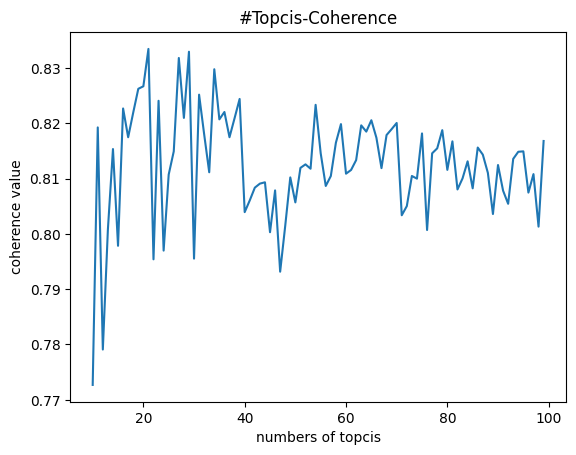

In [ ]:
x = range(10,100)
# z = [perplexity(i) for i in x]  # if perplxity
y = [coherence_metrics(i) for i in x]
plt.plot(x, y)
plt.xlabel('numbers of topcis')
plt.ylabel('coherence value')
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('#Topcis-Coherence')
plt.show()

In [ ]:
df_sample.to_csv('drive/MyDrive/data_sample.xlsx')

In [ ]:
df_coh = pd.DataFrame(y)
df_coh['x'] = x
df_coh.columns = ['coh_score', 'num_topics']
df_coh.sort_values(by=['coh_score'], ascending=False)
# bert_model = bert_topic(50)
# topics, probabilities = bert_model.fit_transform(docs)

,coh_score,num_topics
11,0.833451,21
19,0.832945,29
17,0.831814,27
24,0.829778,34
10,0.826696,20
...,...,...
20,0.795529,30
12,0.795402,22
37,0.793166,47
2,0.779092,12


from matplotlib import pyplot as plt
_df_0['coh_score'].plot(kind='hist', bins=20, title='coh_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['num_topics'].plot(kind='hist', bins=20, title='num_topics')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='coh_score', y='num_topics', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['coh_score'].plot(kind='line', figsize=(8, 4), title='coh_score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['num_topics'].plot(kind='line', figsize=(8, 4), title='num_topics')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
best_topics = 34
bert_model = bert_topic(best_topics)
topics, probabilities = bert_model.fit_transform(docs)

In [ ]:
bert_model.visualize_topics()

In [ ]:
bert_model.visualize_term_rank()

# Category modification

In [ ]:
df_res = pd.DataFrame()

for i in range(-1, 33):
  name_1, prob_1 = bert_model.get_topic(i)[0]
  name_2, prob_2 = bert_model.get_topic(i)[1]
  diff = prob_1 - prob_2

  df_res = pd.concat([df_res, pd.Series([i, name_1, prob_1, name_2, prob_2, diff])], axis=1, ignore_index=True)

df_res = df_res.T
df_res.columns = ['topic', 'name_1', 'prob_1', 'name_2', 'prob_2', 'diff']
df_res = df_res.sort_values(by=['diff'], ascending=False)
df_res[df_res['diff'] > 0.05]

,topic,name_1,prob_1,name_2,prob_2,diff
33,32,moxibustion,0.668963,cervical,0.13817,0.530792
24,23,desk,0.429253,table,0.097882,0.33137
21,20,curtain,0.471854,hook,0.154289,0.317565
15,14,mat,0.369569,toilet,0.1382,0.23137
22,21,fishing,0.327802,pole,0.141495,0.186307
18,17,alarm,0.272499,electronic,0.11111,0.161389
14,13,box,0.221695,earrings,0.073854,0.147842
23,22,filter,0.188101,grinder,0.088331,0.09977
29,28,interior,0.172697,accessory,0.075238,0.097459
30,29,embroidery,0.341176,needle,0.245399,0.095777


In [ ]:
# manually choose topics

dict_temp = {
    16: 'telescope',
    30: 'refrigerator',
    25: 'steam cooker',
    21: 'fishing tools', #badbad
    22: 'coffee maker',
    29: 'needle',
    19: 'broad',
    7: 'bowal and plant',
    12: 'cleaning stuff',
    18: 'tent',
    5: 'anticollision protector',
    1: 'blanket', # like bei zi
    27: 'washing machine',
    9: 'cover',
    31: 'cable',
}

In [ ]:
df_info = bert_model.get_document_info(docs)
df_info.columns = df_info.columns.str.lower()

# update topics dictionary
topic_dict = dict(df_res[['topic', 'name_1']].values)
topic_dict.update(dict_temp)

In [ ]:
# display
topic_dict

{32: 'moxibustion',
 23: 'desk',
 20: 'curtain',
 14: 'mat',
 21: 'fishing tools',
 17: 'alarm',
 13: 'box',
 22: 'coffee maker',
 28: 'interior',
 29: 'needle',
 6: 'cup',
 4: 'cushion',
 19: 'broad',
 25: 'steam cooker',
 11: 'storage',
 26: 'stove',
 30: 'refrigerator',
 16: 'telescope',
 7: 'bowal and plant',
 15: 'screwdriver',
 24: 'kennel',
 0: 'lamp',
 8: 'massage',
 12: 'cleaning stuff',
 2: 'decoration',
 10: 'pad',
 18: 'tent',
 5: 'anticollision protector',
 1: 'blanket',
 27: 'washing machine',
 9: 'cover',
 31: 'cable',
 3: 'jacket',
 -1: 'decoration'}

# reducing datasize and topics

In [ ]:
df_info.probability.describe()

count    20000.000000
mean         0.619967
std          0.320687
min          0.001482
25%          0.328388
50%          0.655451
75%          0.995676
max          1.000000
Name: probability, dtype: float64

<Axes: >

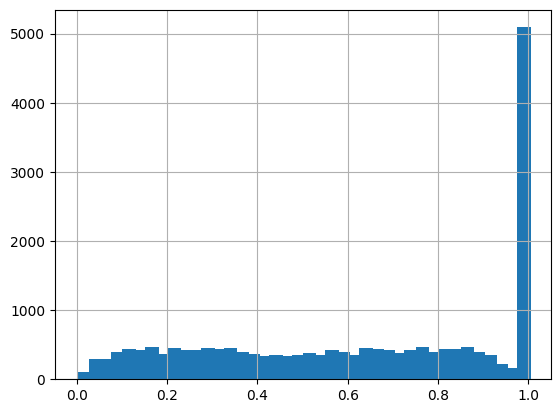

In [ ]:
df_info.probability.hist(width=0.03, bins=40)

In [ ]:
# update df_info
df_info_update = df_info[df_info.probability >= 0.9] # only take 90% probability
df_info_update['topic_name'] = df_info_update.topic.map(lambda x: topic_dict[x]) # update topics name
df_info_update.head()

,document,topic,name,representation,representative_docs,top_n_words,probability,representative_document,topic_name
0,light luxury meter box decorative paint modern...,-1,-1_decoration_pillow_bedroom_diy,"[decoration, pillow, bedroom, diy, accessory, ...",[lead ceiling light Master bedroom light moder...,decoration - pillow - bedroom - diy - accessor...,0.999266,False,decoration
9,bait storage kit Fishing gear kit Fishing gear...,21,21_fishing_pole_equipment_hook,"[fishing, pole, equipment, hook, bracket, wind...",[fishing equipment Childrens rod novice fishin...,fishing - pole - equipment - hook - bracket - ...,1.000000,False,fishing tools
10,long sleeve fitness tight men run sport set sp...,3,3_jacket_winter_motorcycle_knee,"[jacket, winter, motorcycle, knee, pant, fleec...",[knee pad warm leg pad old cold leg windproof ...,jacket - winter - motorcycle - knee - pant - f...,1.000000,False,jacket
11,alarm clock for student special wakeup device ...,17,17_alarm_electronic_student_desktop,"[alarm, electronic, student, desktop, timer, b...",[alarm clock simple home elderly large charact...,alarm - electronic - student - desktop - timer...,1.000000,False,alarm
13,canary cloth flannelette thicken red black wed...,-1,-1_decoration_pillow_bedroom_diy,"[decoration, pillow, bedroom, diy, accessory, ...",[lead ceiling light Master bedroom light moder...,decoration - pillow - bedroom - diy - accessor...,0.911784,False,decoration


In [ ]:
df_sample = pd.read_csv('drive/MyDrive/data_sample.xlsx')
df_sample['topic'] = df_info_update.topic_name
df_sample_update = df_sample.dropna()

In [ ]:
df_sample_update.topic.value_counts()

decoration                 858
lamp                       737
blanket                    530
jacket                     467
cushion                    304
anticollision protector    277
massage                    215
storage                    209
pad                        190
cover                      190
bowal and plant            186
cup                        167
cleaning stuff             146
mat                        111
alarm                       87
fishing tools               86
desk                        85
tent                        85
screwdriver                 83
telescope                   83
coffee maker                82
curtain                     81
kennel                      80
steam cooker                71
stove                       67
box                         63
embroidery                  60
needle                      51
washing machine             48
broad                       47
interior                    41
cable                       22
moxibust

In [ ]:
df_sample_update.shape

(5830, 14)

<Axes: ylabel='category'>

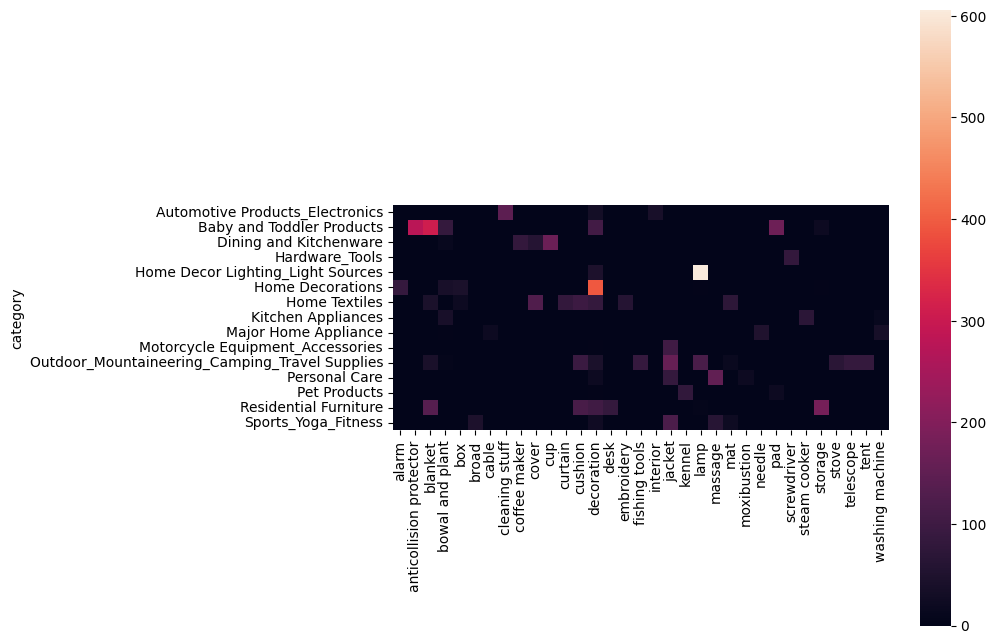

In [ ]:
df_temp = df_sample_update.groupby(['category', 'topic'])[['product_name']].count().unstack()
columns = [x[1] for x in df_temp.columns]
df_temp.columns = columns
df_temp = df_temp.fillna(0)

sns.set_context({"figure.figsize":(8,8)})
sns.heatmap(data=df_temp,square=True)

Image Classification
